# Dataset

In [2]:
import os

# data connection
os.environ['KAGGLE_USERNAME'] = "janpogd"
os.environ['KAGGLE_KEY'] = "KGAT_d36b4545fdf03103e669f0c348baaa63"
!kaggle datasets download -d netflix-inc/netflix-prize-data
!unzip -q netflix-prize-data.zip -d netflix_data

Dataset URL: https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data
License(s): other
netflix-prize-data.zip: Skipping, found more recently modified local copy (use --force to force download)
replace netflix_data/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
!ls netflix_data

combined_data_1.txt  combined_data_3.txt  movie_titles.csv  qualifying.txt
combined_data_2.txt  combined_data_4.txt  probe.txt	    README


In [4]:
import pandas as pd
df_titles = pd.read_csv('netflix_data/movie_titles.csv',
                         encoding='ISO-8859-1',
                         header=None,
                         on_bad_lines='skip')

print("--- RAMKA: Tytuły Filmów (movie_titles.csv) ---")
print(f"Kształt: {df_titles.shape}")
df_titles.columns = ["Id", "Year", "Movie"]
display(df_titles.head())

--- RAMKA: Tytuły Filmów (movie_titles.csv) ---
Kształt: (17434, 3)


,Id,Year,Movie
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('netflix_data/combined_data_1.txt', header=None, names=['Cust_Id', 'Rating', 'Date'], nrows=2000000)

movie_id_indices = df[df['Rating'].isna()].index
movie_id_values = df.iloc[movie_id_indices]['Cust_Id'].str.replace(':', '').astype(int)
df.loc[movie_id_indices, 'Movie_Id'] = movie_id_values

# 4. we Use ffill() (forward fill), to connect ID to all ratings with him
df['Movie_Id'] = df['Movie_Id'].ffill()
df = df.dropna(subset=['Rating'])

# types
df['Movie_Id'] = df['Movie_Id'].astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
df['Rating'] = df['Rating'].astype(float)

print("--- POPRAWIONA RAMKA DANYCH ---")
display(df.head())
print(f"\nKształt ramki: {df.shape}")

--- POPRAWIONA RAMKA DANYCH ---


,Cust_Id,Rating,Date,Movie_Id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1



Kształt ramki: (1999639, 4)


In [6]:
# Probe.txt - to validate
df_probe = pd.read_csv('netflix_data/probe.txt', header=None, nrows=10, names=['Data'], on_bad_lines='skip')
print("\n--- RAMKA: Probe (Próbka walidacyjna) ---")
display(df_probe.head())

# Qualifying.txt - to predict (competition)
df_qualifying = pd.read_csv('netflix_data/qualifying.txt', header=None, nrows=10, names=['Data'],  on_bad_lines='skip')
print("\n--- RAMKA: Qualifying (Zestaw konkursowy) ---")
display(df_qualifying.head())


--- RAMKA: Probe (Próbka walidacyjna) ---


,Data
0,1:
1,30878
2,2647871
3,1283744
4,2488120



--- RAMKA: Qualifying (Zestaw konkursowy) ---


,Data
0,1:
1,10:
2,1000:
3,10000:
4,10001:


# Reccomendations

## 1. Average based reccomendations

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# load 2mln rows
df_raw = pd.read_csv('netflix_data/combined_data_1.txt', header=None, names=['Cust_Id', 'Rating', 'Date'], nrows=2000000)

# cleaning
movie_id_indices = df_raw[df_raw['Rating'].isna()].index
movie_id_values = df_raw.iloc[movie_id_indices]['Cust_Id'].str.replace(':', '').astype(int)
df_raw.loc[movie_id_indices, 'Movie_Id'] = movie_id_values
df_raw['Movie_Id'] = df_raw['Movie_Id'].ffill()
df = df_raw.dropna(subset=['Rating']).copy()
df['Rating'] = df['Rating'].astype(float)

# --- SPLIT ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train set: {len(train_df)} ratings")
print(f"Test set: {len(test_df)} ratings")

Train set: 1599711 ratings
Test set: 399928 ratings


In [8]:
# movie mean
movie_means = train_df.groupby('Movie_Id')['Rating'].mean()

# global mean
global_mean = train_df['Rating'].mean()

# 3. predictions
test_df['Prediction'] = test_df['Movie_Id'].map(movie_means).fillna(global_mean)

display(test_df[['Movie_Id', 'Cust_Id', 'Rating', 'Prediction']].head())

,Movie_Id,Cust_Id,Rating,Prediction
392569,111.0,1405518,3.0,3.079623
1095048,252.0,1388232,5.0,3.392518
1706027,329.0,1269695,3.0,3.586936
1006485,232.0,1338823,4.0,3.185790
858404,197.0,1183724,4.0,3.480823


In [9]:
rmse = np.sqrt(mean_squared_error(test_df['Rating'], test_df['Prediction']))

print(f"--- WYNIKI ---")
print(f"Globalna średnia w bazie: {global_mean:.2f}")
print(f"Błąd RMSE Twojego pierwszego modelu: {rmse:.4f}")

--- WYNIKI ---
Globalna średnia w bazie: 3.62
Błąd RMSE Twojego pierwszego modelu: 1.0202


# 2. Baseline

In [10]:
# mean for each user
user_means = train_df.groupby('Cust_Id')['Rating'].mean()

# 2. predictions: mapping users for them averages
test_df['User_Mean_Pred'] = test_df['Cust_Id'].map(user_means).fillna(global_mean)

rmse_user = np.sqrt(mean_squared_error(test_df['Rating'], test_df['User_Mean_Pred']))
print(f"RMSE (User Mean): {rmse_user:.4f}")

# biases
movie_bias = movie_means - global_mean
user_bias = user_means - global_mean

# baseline predictions
test_df['Movie_Bias'] = test_df['Movie_Id'].map(movie_bias).fillna(0)
test_df['User_Bias'] = test_df['Cust_Id'].map(user_bias).fillna(0)

test_df['Baseline_Pred'] = global_mean + test_df['Movie_Bias'] + test_df['User_Bias']
test_df['Baseline_Pred'] = test_df['Baseline_Pred'].clip(1, 5)

rmse_baseline = np.sqrt(mean_squared_error(test_df['Rating'], test_df['Baseline_Pred']))
print(f"RMSE (Baseline Movie+User): {rmse_baseline:.4f}")

RMSE (User Mean): 1.0905
RMSE (Baseline Movie+User): 1.0394


# Ensemble User + Movie Means

In [11]:
from sklearn.linear_model import LinearRegression

X_ensemble = test_df[['Prediction', 'User_Mean_Pred']] # 'Prediction' as Movie_Mean
y_ensemble = test_df['Rating']

ensemble_model = LinearRegression()
ensemble_model.fit(X_ensemble, y_ensemble)

test_df['Ensemble_Pred'] = ensemble_model.predict(X_ensemble).clip(1, 5)

rmse_ensemble = np.sqrt(mean_squared_error(test_df['Rating'], test_df['Ensemble_Pred']))
print(f"RMSE (Ensemble: Movie Mean + User Mean): {rmse_ensemble:.4f}")

RMSE (Ensemble: Movie Mean + User Mean): 0.9848


 # Linear Regression, SVD, xgBoost

In [49]:
train_df

,Cust_Id,Rating,Date,Movie_Id,movie_avg,user_avg,year
26201,2565961,4.0,2005-08-13,17.0,2.900194,3.800000,2005.0
213490,1034825,5.0,2004-11-17,33.0,4.161325,5.000000,2000.0
1601687,2218591,3.0,2005-04-05,313.0,3.685706,4.000000,2000.0
1567888,1035650,5.0,2003-02-21,313.0,3.685706,3.136364,2000.0
908689,2425741,4.0,2003-02-13,199.0,3.894406,2.478261,1978.0
...,...,...,...,...,...,...,...
259235,1783108,5.0,2005-06-24,57.0,3.675306,4.100000,1995.0
1414713,853344,4.0,2005-05-02,299.0,3.706638,4.333333,2001.0
131962,1973503,4.0,2004-04-05,30.0,3.759764,3.347826,2003.0
671335,1830936,3.0,2004-10-06,180.0,3.855665,3.142857,2002.0


In [24]:
df_titles = pd.read_csv('netflix_data/movie_titles.csv',
                         encoding='ISO-8859-1',
                         header=None,
                         names=['Movie_Id', 'Year', 'Name'],
                         on_bad_lines='skip')

# 2. to prepare featares for ML based apporach
def prepare_features(df, movie_means, user_means, titles_df):
    df_feat = df.copy()

    df_feat['movie_avg'] = df_feat['Movie_Id'].map(movie_means)
    df_feat['user_avg'] = df_feat['Cust_Id'].map(user_means)

    # year map
    year_map = titles_df.set_index('Movie_Id')['Year']
    df_feat['year'] = df_feat['Movie_Id'].map(year_map).fillna(1900)

    # only numerical features
    return df_feat[['movie_avg', 'user_avg', 'year']], df_feat['Rating']

# train
X_train, y_train = prepare_features(train_df, movie_means, user_means, df_titles)
X_test, y_test = prepare_features(test_df, movie_means, user_means, df_titles)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

lr_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("lr", LinearRegression())
])

In [25]:
!pip install scikit-surprise -q

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from surprise import SVD, Reader, Dataset
from surprise.accuracy import rmse as surprise_rmse
import numpy as np

# ===============================
# --- 1. LinearReg ---
lr_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("lr", LinearRegression())
])

lr_pipe.fit(X_train, y_train)
pred_lr = lr_pipe.predict(X_test).clip(1, 5)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
print(f"RMSE LinearRegression: {rmse_lr:.4f}")

# ===============================
# --- 2. XGBoost ---
xgb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("xgb", XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        n_jobs=-1,
        random_state=42
    ))
])

xgb_pipe.fit(X_train, y_train)
pred_xgb = xgb_pipe.predict(X_test).clip(1, 5)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(f"RMSE XGBoost: {rmse_xgb:.4f}")

# ===============================
# --- 3. SVD (Matrix Factorization) ---
reader = Reader(rating_scale=(1, 5))

# Trening
data_train = Dataset.load_from_df(
    train_df[['Cust_Id', 'Movie_Id', 'Rating']], reader
).build_full_trainset()

# Test
data_test = Dataset.load_from_df(
    test_df[['Cust_Id', 'Movie_Id', 'Rating']], reader
).build_full_trainset().build_testset()

# Model SVD
svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(data_train)

# RMSE
predictions_svd = svd_model.test(data_test)
rmse_svd = surprise_rmse(predictions_svd)
print(f"RMSE SVD: {rmse_svd:.4f}")


RMSE LinearRegression: 1.0327
RMSE XGBoost: 1.0372
RMSE: 0.9876
RMSE SVD: 0.9876


/tmp/ipython-input-1622948327.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(results.keys()), y=list(results.values()), palette=colors)


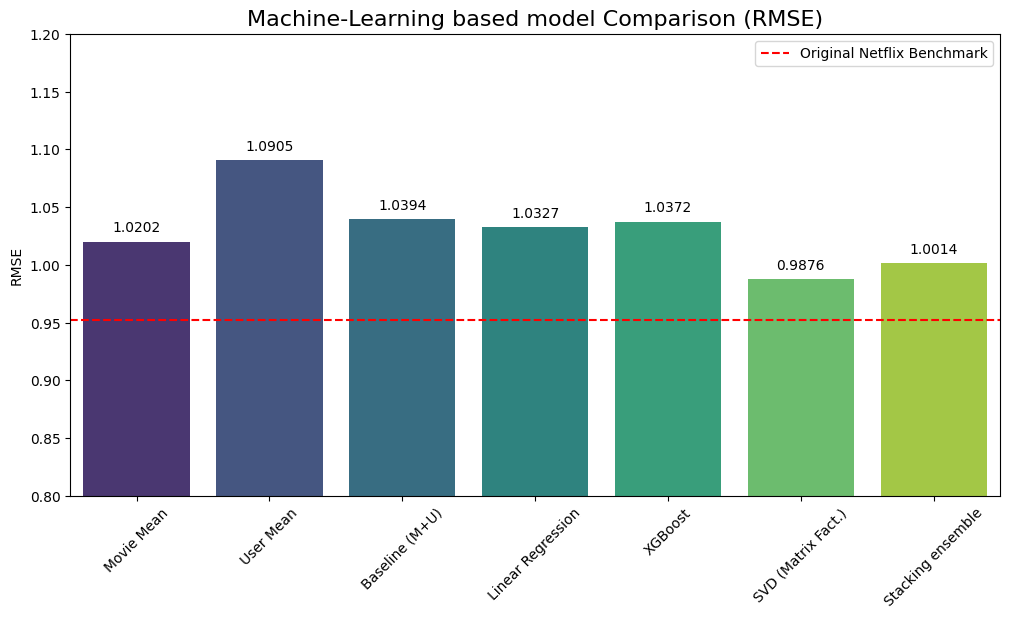

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# results from above
results = {
    'Movie Mean': 1.0202,
    'User Mean': 1.0905,
    'Baseline (M+U)': 1.0394,
    'Linear Regression': 1.0327,
    'XGBoost': 1.0372,
    'SVD (Matrix Fact.)': 0.9876,
    'Stacking ensemble': 1.0014
}

plt.figure(figsize=(12, 6))
colors = sns.color_palette('viridis', len(results))
ax = sns.barplot(x=list(results.keys()), y=list(results.values()), palette=colors)
plt.axhline(y=0.9525, color='red', linestyle='--', label='Original Netflix Benchmark')

plt.title('Machine-Learning based model Comparison (RMSE)', fontsize=16)
plt.ylabel('RMSE')
plt.ylim(0.8, 1.2)
plt.xticks(rotation=45)
plt.legend()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# Ensemble

In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from surprise import SVD, Reader, Dataset
from surprise.accuracy import rmse as surprise_rmse
from sklearn.metrics import mean_squared_error

# ===============================
# LinearRegression pipeline
lr_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("lr", LinearRegression())
])
lr_pipe.fit(X_train, y_train)
pred_lr = lr_pipe.predict(X_test).clip(1, 5)

# XGBoost pipeline
xgb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("xgb", XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, n_jobs=-1, random_state=42))
])
xgb_pipe.fit(X_train, y_train)
pred_xgb = xgb_pipe.predict(X_test).clip(1, 5)

# SVD
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(train_df[['Cust_Id', 'Movie_Id', 'Rating']], reader).build_full_trainset()
data_test = Dataset.load_from_df(test_df[['Cust_Id', 'Movie_Id', 'Rating']], reader).build_full_trainset().build_testset()
svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(data_train)
predictions_svd = svd_model.test(data_test)
pred_svd = np.array([pred.est for pred in predictions_svd]).clip(1, 5)

# ===============================
# --- 1. Soft Voting ---
pred_soft_voting = (pred_lr + pred_xgb + pred_svd) / 3
rmse_soft = np.sqrt(mean_squared_error(y_test, pred_soft_voting))
print(f"RMSE Soft Voting Ensemble: {rmse_soft:.4f}")

# ===============================
# --- 2. Stacking (LinearRegression as meta-model) ---
X_meta = np.vstack([pred_lr, pred_xgb, pred_svd]).T

# Meta-model
stack_model = LinearRegression()
stack_model.fit(X_meta, y_test)
pred_stack = stack_model.predict(X_meta).clip(1, 5)
rmse_stack = np.sqrt(mean_squared_error(y_test, pred_stack))
print(f"RMSE Stacking Ensemble: {rmse_stack:.4f}")


RMSE Soft Voting Ensemble: 1.0151
RMSE Stacking Ensemble: 1.0014


# 2. BM25

In [46]:
X_train

,movie_avg,user_avg,year
26201,2.900194,3.800000,2005.0
213490,4.161325,5.000000,2000.0
1601687,3.685706,4.000000,2000.0
1567888,3.685706,3.136364,2000.0
908689,3.894406,2.478261,1978.0
...,...,...,...
259235,3.675306,4.100000,1995.0
1414713,3.706638,4.333333,2001.0
131962,3.759764,3.347826,2003.0
671335,3.855665,3.142857,2002.0


In [36]:
X_train, y_train = prepare_features(train_df, movie_means, user_means, df_titles)
X_test, y_test = prepare_features(test_df, movie_means, user_means, df_titles)

In [40]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class FastBM25Feature(BaseEstimator, TransformerMixin):
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.idf = {}
        self.movie_stats = {}
        self.avgdl = 0

    def fit(self, X, y=None):
        # N = all movies number
        N = X['Movie_Id'].nunique()

        # 1. compute IDF for each user
        # n(u) = in how many movies does user appear
        user_counts = X.groupby('Cust_Id')['Movie_Id'].count()
        self.idf = np.log((N - user_counts + 0.5) / (user_counts + 0.5) + 1).to_dict()

        # 2. statistics - documents (movies) length
        movie_lengths = X.groupby('Movie_Id')['Cust_Id'].count()
        self.movie_stats = movie_lengths.to_dict()
        self.avgdl = movie_lengths.mean()

        return self

    def transform(self, X):
        # get IDF for Cust_Id (default 0)
        # get len for Movie_Id (default avgdl)

        # mapping vectorization
        idf_vec = X['Cust_Id'].map(self.idf).fillna(1e-6).values
        len_d_vec = X['Movie_Id'].map(self.movie_stats).fillna(self.avgdl).values

        # formula BM25 (uproszczony dla TF=1)
        # Score = IDF * (TF * (k1 + 1)) / (TF + k1 * (1 - b + b * (len_d / avgdl)))
        numerator = idf_vec * (self.k1 + 1)
        denominator = 1 + self.k1 * (1 - self.b + self.b * (len_d_vec / self.avgdl))

        return (numerator / denominator).reshape(-1, 1)

def get_numeric_features(df):
  # to get numeric
    return df[['movie_avg', 'user_avg', 'year']].values

# 2. pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', FunctionTransformer(get_numeric_features)),
        ('bm25', FastBM25Feature(k1=1.2, b=0.8))
    ])),
    ('imputer', SimpleImputer(strategy="mean")),
    ('lr', LinearRegression())
])

# training
train_df['movie_avg'] = train_df['Movie_Id'].map(movie_means)
train_df['user_avg'] = train_df['Cust_Id'].map(user_means)
train_df['year'] = train_df['Movie_Id'].map(df_titles.set_index('Movie_Id')['Year']).fillna(1900)

test_df['movie_avg'] = test_df['Movie_Id'].map(movie_means)
test_df['user_avg'] = test_df['Cust_Id'].map(user_means)
test_df['year'] = test_df['Movie_Id'].map(df_titles.set_index('Movie_Id')['Year']).fillna(1900)
pipeline.fit(train_df, train_df['Rating'])
pred_final = pipeline.predict(test_df).clip(1, 5)
rmse_final = np.sqrt(mean_squared_error(test_df['Rating'], pred_final))

print(f"RMSE (LogReg + FastBM25): {rmse_final:.4f}")

RMSE (LogReg + FastBM25): 1.0325


# Grapgh-based

In [ ]:
!pip install torch_geometric

# Graph visualization

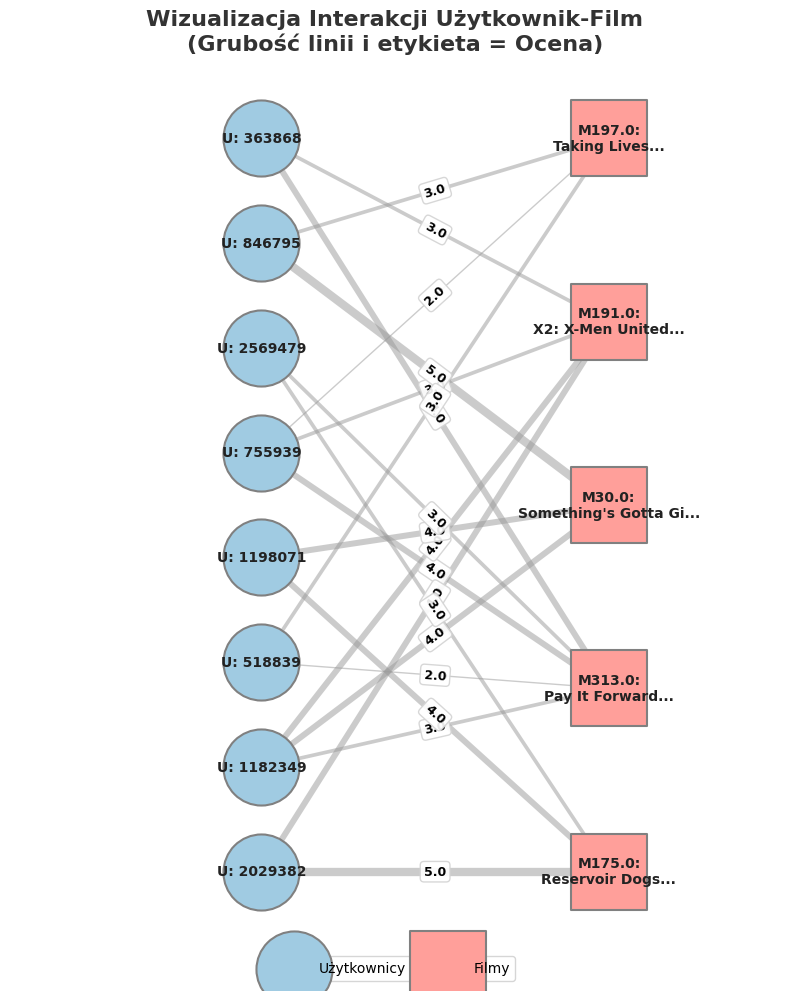

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Prepocessing ---
df_titles.columns = ["Movie_Id", "Movie_Year", "Movie_Name"]
try:
    sample_size = 50000
    df_sample = train_df.head(sample_size).copy()
    top_movies = df_sample['Movie_Id'].value_counts().head(5).index
    top_users = df_sample[df_sample['Movie_Id'].isin(top_movies)]['Cust_Id'].value_counts().head(8).index
    viz_df = df_sample[
        (df_sample['Movie_Id'].isin(top_movies)) &
        (df_sample['Cust_Id'].isin(top_users))
    ].copy()
    viz_df = viz_df.merge(df_titles[['Movie_Id', 'Movie_Name']], on='Movie_Id', how='left')
except NameError:
    print("Błąd: Brakuje zmiennych 'train_df' i 'df_titles'. Upewnij się, że są wczytane.")
    exit()

# --- 2. NetworkX graph construction ---
B = nx.Graph()

# shorter movie names
viz_df['ShortName'] = viz_df['Movie_Name'].str[:20] + '...'
# Movie ID to label and User Id to user
viz_df['MovieLabel'] = 'M' + viz_df['Movie_Id'].astype(str) + ':\n' + viz_df['ShortName']
viz_df['UserLabel'] = 'U: ' + viz_df['Cust_Id'].astype(str)

user_nodes = viz_df['UserLabel'].unique().tolist()
movie_nodes = viz_df['MovieLabel'].unique().tolist()

B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(movie_nodes, bipartite=1)

for _, row in viz_df.iterrows():
    B.add_edge(row['UserLabel'], row['MovieLabel'], weight=row['Rating'])

# --- 3. Visualization -----
fig, ax = plt.subplots(figsize=(8, 10), facecolor='white')
ax.set_facecolor('white')
plt.title("Wizualizacja Interakcji Użytkownik-Film\n(Grubość linii i etykieta = Ocena)",
          fontsize=16, fontweight='bold', pad=20, color='#333333')
# bipartite
pos = nx.bipartite_layout(B, user_nodes)

# users
nx.draw_networkx_nodes(B, pos, nodelist=user_nodes,
                       node_color='#A0CBE2',
                       node_shape='o', node_size=3000,
                       edgecolors='grey', linewidths=1.5,
                       label='Użytkownicy')

# movies
nx.draw_networkx_nodes(B, pos, nodelist=movie_nodes,
                       node_color='#FF9F9A',
                       node_shape='s', node_size=3000,
                       edgecolors='grey', linewidths=1.5,
                       label='Filmy')

nx.draw_networkx_labels(B, pos, font_size=10, font_weight='bold', font_color='#222222')
weights = np.array([B[u][v]['weight'] for u,v in B.edges()])
widths = 1 + (weights - weights.min()) / (weights.max() - weights.min()) * 5

nx.draw_networkx_edges(B, pos,
                       width=widths,
                       alpha=0.5,
                       edge_color='#999999')

edge_labels = nx.get_edge_attributes(B, 'weight')
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="lightgrey", lw=1, alpha=0.9)

nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels,
                             font_size=9, font_color='black', font_weight='bold',
                             bbox=bbox_props)

ax.set_xlim(-1.8, 1.8)
y_values = [y for x,y in pos.values()]
ax.set_ylim(min(y_values) - 0.1, max(y_values) + 0.1)


plt.legend(scatterpoints=1, frameon=True, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)
plt.axis('off')
plt.tight_layout()
plt.show()

In [38]:
from pyvis.network import Network
import networkx as nx
import pandas as pd
from IPython.display import HTML

sample_size = 100000
df_sample = train_df.head(sample_size).copy()
df_sample['Cust_Id'] = df_sample['Cust_Id'].astype(int)
df_sample['Movie_Id'] = df_sample['Movie_Id'].astype(int)

B_full = nx.Graph()

edges = []
for _, row in df_sample.iterrows():
    u_node = f"User_{row['Cust_Id']}"
    m_node = f"Movie_{row['Movie_Id']}"
    edges.append((u_node, m_node, row['Rating']))

B_full.add_weighted_edges_from(edges)

# --- 2. filtering ---
degree_dict = dict(B_full.degree())
min_user_degree = 5
nodes_to_keep = [
    n for n, d in degree_dict.items()
    if (n.startswith('Movie_')) or (n.startswith('User_') and d >= min_user_degree)
]

B_sub = B_full.subgraph(nodes_to_keep).copy()
B_sub.remove_nodes_from(list(nx.isolates(B_sub)))

# --- 3.  PYVIS  ---
net = Network(
    height='800px',
    width='100%',
    bgcolor='#000000',
    font_color='white',
    notebook=True,
    cdn_resources='remote',
    heading='Mapa Interakcji User-Movie'
)

net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

for node in B_sub.nodes():
    deg = B_sub.degree(node)

    if node.startswith('Movie_'):
        try:
            m_id_raw = node.split('_')[1]
            m_id = int(float(m_id_raw))

            title_search = df_titles[df_titles['Movie_Id'] == m_id]['Movie_Name'].values
            title = title_search[0] if len(title_search) > 0 else f"Movie ID: {m_id}"

            net.add_node(node, label=title, title=f"Film: {title}\nLiczba ocen: {deg}",
                         color='#ff4d4d', size=20 + (deg/2), shape='dot')
        except Exception as e:
            print(f"Problem z węzłem {node}: {e}")
    else:
        net.add_node(node, label=node, title=f"Użytkownik\nAktywność: {deg}",
                     color='#4d94ff', size=15, shape='dot')

for u, v, data in B_sub.edges(data=True):
    net.add_edge(u, v, value=data['weight'], color='#444444', alpha=0.6)

net.show("graph_netflix1.html")
HTML(filename="graph_netflix1.html")

graph_netflix1.html


# Community detection

In [39]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
from IPython.display import HTML
from networkx.algorithms.community import louvain_communities

# --- 1. preprocessing  ---
train_df['Cust_Id'] = train_df['Cust_Id'].astype(int)
train_df['Movie_Id'] = train_df['Movie_Id'].astype(int)
df_titles['Movie_Id'] = df_titles['Movie_Id'].astype(int)

sample_size = 120000
df_sample = train_df.head(sample_size).copy()

B = nx.Graph()
for _, row in df_sample.iterrows():
    B.add_edge(f"U_{row['Cust_Id']}", f"M_{row['Movie_Id']}", weight=row['Rating'])

# --- 2. filtering ---
degree_dict = dict(B.degree())
nodes_to_keep = [n for n, d in degree_dict.items() if d >= 10 or n.startswith('M_')]
B_sub = B.subgraph(nodes_to_keep).copy()
B_sub.remove_nodes_from(list(nx.isolates(B_sub)))

# --- 3. LOUVAIN ---
communities = louvain_communities(B_sub, seed=42)
top_5_communities = sorted(communities, key=len, reverse=True)[:5]

node_to_community = {}
for i, comm in enumerate(top_5_communities):
    for node in comm:
        node_to_community[node] = i

# --- 4. PYVIS ---
net = Network(height='800px', width='100%',
              bgcolor='#000000',
              font_color='#ffffff',
              notebook=True,
              cdn_resources='remote')

colors = ['#FF5733', '#33FF57', '#3357FF', '#F333FF', '#FFBD33', '#444444']

for node in B_sub.nodes():
    comm_id = node_to_community.get(node, 5)
    node_color = colors[comm_id]
    shape = 'dot' if node.startswith('U_') else 'square'

    label = ""
    title = f"Użytkownik: {node}"

    if node.startswith('M_'):
        try:
            m_id = int(float(node.split('_')[1]))
            movie_row = df_titles[df_titles['Movie_Id'] == m_id]

            if not movie_row.empty:
                full_title = movie_row['Movie_Name'].values[0]
                label = full_title[:20] + "..."
                title = f"Film: {full_title}\nGrupa: {comm_id + 1}"
            else:
                full_title = "Nieznany"
        except:
            full_title = "Błąd"

    net.add_node(node, label=label, title=title, color=node_color,
                 shape=shape, size=25 if shape=='square' else 12)

# Edges
nodes_in_net = net.get_nodes()
for u, v, data in B_sub.edges(data=True):
    if u in nodes_in_net and v in nodes_in_net:
        u_comm = node_to_community.get(u)
        v_comm = node_to_community.get(v)
        # colors relate to community
        if u_comm == v_comm and u_comm is not None:
            edge_color = colors[u_comm]
            alpha = 0.3
        else:
            edge_color = '#222222'
            alpha = 0.1

        net.add_edge(u, v, color=edge_color, alpha=alpha)

net.set_options("""
var options = {
  "physics": {
    "barnesHut": { "gravitationalConstant": -25000, "springLength": 250 },
    "minVelocity": 0.75
  }
}
""")

net.show("community_map_dark.html")
display(HTML("community_map_dark.html"))

community_map_dark.html


In [28]:
df_titles

,Movie_Id,Movie_Year,Movie_Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17429,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17430,17767,2004.0,Fidel Castro: American Experience
17431,17768,2000.0,Epoch
17432,17769,2003.0,The Company


In [25]:
df_titles

,Id,Year,Movie
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17429,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17430,17767,2004.0,Fidel Castro: American Experience
17431,17768,2000.0,Epoch
17432,17769,2003.0,The Company


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

class LightGCNLayer(MessagePassing):
    def __init__(self):
        super(LightGCNLayer, self).__init__(aggr='add')

    def forward(self, x, edge_index):
        # Compute normalization (1/sqrt(deg(i)*deg(j)))
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Propagation of forward move
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, n_layers):
        super(LightGCN, self).__init__()
        self.users_emb = nn.Embedding(num_users, embedding_dim)
        self.items_emb = nn.Embedding(num_items, embedding_dim)
        self.layers = nn.ModuleList([LightGCNLayer() for _ in range(n_layers)])

        # Wages initialization
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index):
        x = torch.cat([self.users_emb.weight, self.items_emb.weight], dim=0)
        all_embs = [x]

        for layer in self.layers:
            x = layer(x, edge_index)
            all_embs.append(x)

        # Average of embedings from all of the layers
        final_embs = torch.mean(torch.stack(all_embs, dim=0), dim=0)
        return torch.split(final_embs, [self.users_emb.num_embeddings, self.items_emb.num_embeddings])

# Prediciton: Dot product of final embedings
def predict_rating(user_embs, item_embs, user_indices, item_indices):
    return (user_embs[user_indices] * item_embs[item_indices]).sum(dim=-1)

In [28]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data

# 1. mapping Cust_Id i Movie_Id for indexes 0..N
user_ids = train_df['Cust_Id'].unique()
movie_ids = train_df['Movie_Id'].unique()

user_map = {id: i for i, id in enumerate(user_ids)}
movie_map = {id: i for i, id in enumerate(movie_ids)}

num_users = len(user_ids)
num_movies = len(movie_ids)

# 2. Edge Index creation
# In bipartite graph movie_id gets offset equals to users connections
u_indices = train_df['Cust_Id'].map(user_map).values
m_indices = train_df['Movie_Id'].map(movie_map).values + num_users

# two directional edges for Message Passing
u_to_m = torch.tensor([u_indices, m_indices], dtype=torch.long)
m_to_u = torch.tensor([m_indices, u_indices], dtype=torch.long)
edge_index = torch.cat([u_to_m, m_to_u], dim=1)

# Bencmbark
ratings = torch.tensor(train_df['Rating'].values, dtype=torch.float)

print(f"Graf gotowy: {num_users} użytkowników, {num_movies} filmów, {edge_index.shape[1]} krawędzi.")

Graf gotowy: 5037 użytkowników, 231 filmów, 10240 krawędzi.


/tmp/ipython-input-1070164161.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  u_to_m = torch.tensor([u_indices, m_indices], dtype=torch.long)


In [18]:
# Init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightGCN(num_users=num_users, num_items=num_movies, embedding_dim=64, n_layers=3).to(device)
# Weight Decay (L2) and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

def train_enhanced():
    model.train()
    optimizer.zero_grad()

    user_embs, item_embs = model(edge_index)

    train_u_idx = torch.tensor(u_indices, dtype=torch.long).to(device)
    train_m_idx = torch.tensor(m_indices - num_users, dtype=torch.long).to(device)

    # pred
    predictions = predict_rating(user_embs, item_embs, train_u_idx, train_m_idx)

    # function loss
    loss = F.mse_loss(predictions, ratings)

    loss.backward()
    optimizer.step()
    return loss.item()

# loop for training
for epoch in range(1, 5001):
    loss = train_enhanced()
    current_rmse = np.sqrt(loss)

    # Scheduler actualizes LR based on RMSE
    scheduler.step(current_rmse)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, RMSE: {current_rmse:.4f}, LR: {optimizer.param_groups[0]["lr"]}')

    # Early Stopping
    if optimizer.param_groups[0]['lr'] < 1e-6:
        print("Learning rate zbyt mały. Kończymy.")
        break

Epoch 010, Loss: 6.3180, RMSE: 2.5136, LR: 0.01
Epoch 020, Loss: 3.3321, RMSE: 1.8254, LR: 0.01
Epoch 030, Loss: 2.6413, RMSE: 1.6252, LR: 0.01
Epoch 040, Loss: 2.5221, RMSE: 1.5881, LR: 0.01
Epoch 050, Loss: 2.3512, RMSE: 1.5334, LR: 0.01
Epoch 060, Loss: 2.2390, RMSE: 1.4963, LR: 0.01
Epoch 070, Loss: 2.0628, RMSE: 1.4362, LR: 0.01
Epoch 080, Loss: 1.8739, RMSE: 1.3689, LR: 0.01
Epoch 090, Loss: 1.7127, RMSE: 1.3087, LR: 0.01
Epoch 100, Loss: 1.6113, RMSE: 1.2694, LR: 0.01
Epoch 110, Loss: 1.5465, RMSE: 1.2436, LR: 0.01
Epoch 120, Loss: 1.4954, RMSE: 1.2229, LR: 0.01
Epoch 130, Loss: 1.4547, RMSE: 1.2061, LR: 0.01
Epoch 140, Loss: 1.4194, RMSE: 1.1914, LR: 0.01
Epoch 150, Loss: 1.3851, RMSE: 1.1769, LR: 0.01
Epoch 160, Loss: 1.3522, RMSE: 1.1628, LR: 0.01
Epoch 170, Loss: 1.3212, RMSE: 1.1494, LR: 0.01
Epoch 180, Loss: 1.2929, RMSE: 1.1371, LR: 0.01
Epoch 190, Loss: 1.2678, RMSE: 1.1260, LR: 0.01
Epoch 200, Loss: 1.2455, RMSE: 1.1160, LR: 0.01
Epoch 210, Loss: 1.2251, RMSE: 1.1068, L

# test set

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

all_user_ids = df['Cust_Id'].unique()
all_movie_ids = df['Movie_Id'].unique()

user_map = {id: i for i, id in enumerate(all_user_ids)}
movie_map = {id: i for i, id in enumerate(all_movie_ids)}

num_users = len(all_user_ids)
num_movies = len(all_movie_ids)

# 2. Split for mapping
df['u_idx'] = df['Cust_Id'].map(user_map)
df['m_idx'] = df['Movie_Id'].map(movie_map)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_torch(df_subset):
    u = torch.tensor(df_subset['u_idx'].values, dtype=torch.long).to(device)
    m = torch.tensor(df_subset['m_idx'].values, dtype=torch.long).to(device)
    r = torch.tensor(df_subset['Rating'].values, dtype=torch.float).to(device)
    return u, m, r

train_u, train_m, train_r = to_torch(train_df)
test_u, test_m, test_r = to_torch(test_df)

# 4. edges only from training
u_indices = train_df['u_idx'].values
m_indices = train_df['m_idx'].values + num_users

u_to_m = torch.tensor([u_indices, m_indices], dtype=torch.long)
m_to_u = torch.tensor([m_indices, u_indices], dtype=torch.long)
edge_index = torch.cat([u_to_m, m_to_u], dim=1).to(device)

# 5. model
model = LightGCN(num_users=num_users, num_items=num_movies, embedding_dim=64, n_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

# 6. loop
print(f"Start: {num_users} users, {num_movies} movies. Training on {device}...")

for epoch in range(1, 1001):
    model.train()
    optimizer.zero_grad()

    # Forward pass (generowanie embeddingów na podstawie grafu treningowego)
    user_embs, item_embs = model(edge_index)

    # Training: RMSE
    train_preds = predict_rating(user_embs, item_embs, train_u, train_m)
    train_loss = F.mse_loss(train_preds, train_r)

    train_loss.backward()
    optimizer.step()

    # validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Test: RMSE on the same embedings, for test indeces
            test_preds = predict_rating(user_embs, item_embs, test_u, test_m)
            test_rmse = torch.sqrt(F.mse_loss(test_preds, test_r))
            train_rmse = torch.sqrt(train_loss)

            print(f'Epoch {epoch:03d} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}')

Start: 342416 users, 361 movies. Training on cpu...
Epoch 010 | Train RMSE: 2.5152 | Test RMSE: 2.5871


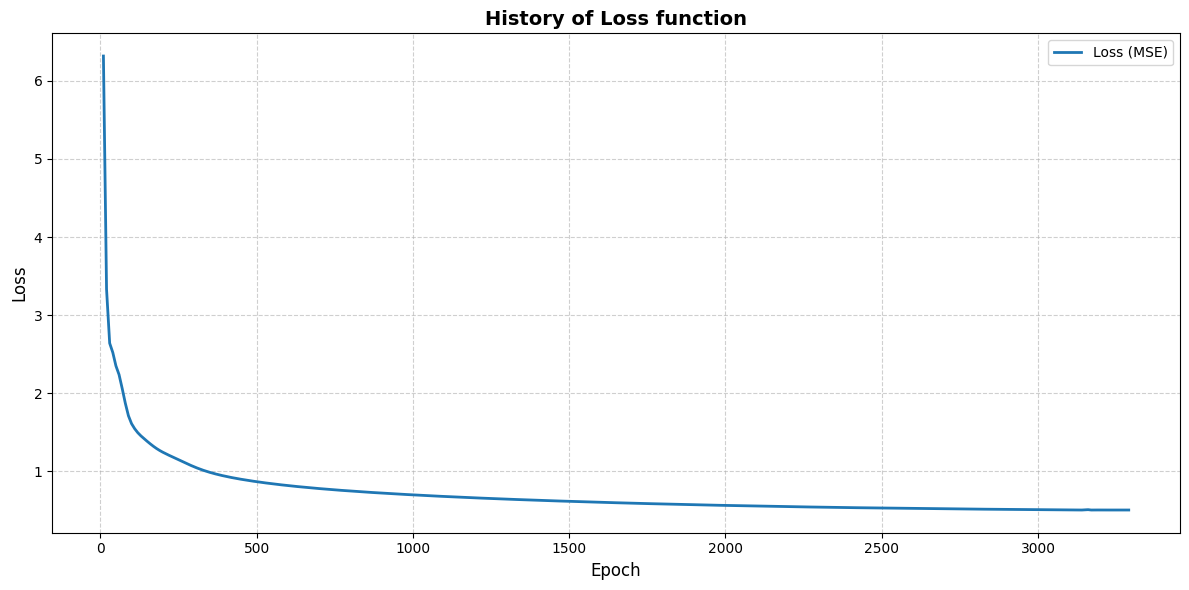

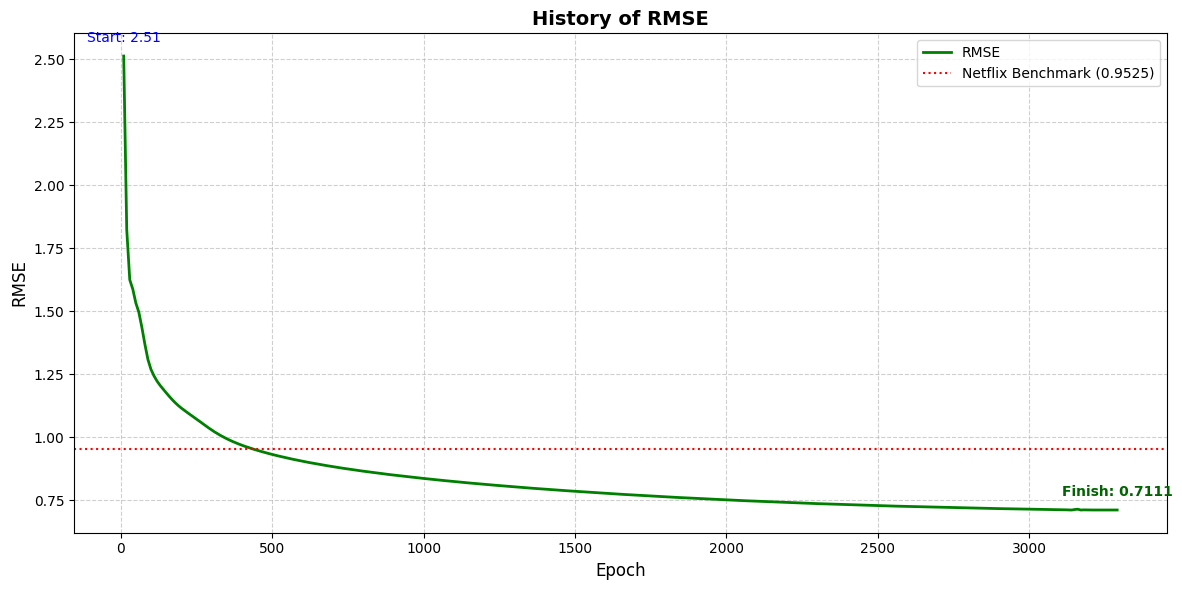

In [23]:
import matplotlib.pyplot as plt
import re

log_data ="""
"""
epochs, losses, rmses, lrs = [], [], [], []
pattern = re.compile(r"Epoch (\d+), Loss: ([\d.]+), RMSE: ([\d.]+), LR: ([\d.e-]+)")

for line in log_data.strip().split('\n'):
    match = pattern.search(line)
    if match:
        epochs.append(int(match.group(1)))
        losses.append(float(match.group(2)))
        rmses.append(float(match.group(3)))
        lrs.append(float(match.group(4)))

# --- LOSS (MSE) ---
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, label='Loss (MSE)', color='#1f77b4', linewidth=2)
plt.title('History of Loss function', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(0, 3500, 500))
plt.legend()
plt.tight_layout()
plt.show()

# --- RMSE + BENCHMARK ---
plt.figure(figsize=(12, 6))
plt.plot(epochs, rmses, label='RMSE', color='green', linewidth=2)

# Benchmark Netflix
plt.axhline(y=0.9525, color='red', linestyle=':', label='Netflix Benchmark (0.9525)')

if rmses:
    plt.annotate(f'Start: {rmses[0]:.2f}', (epochs[0], rmses[0]),
                 textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f'Finish: {rmses[-1]:.4f}', (epochs[-1], rmses[-1]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold', color='darkgreen')

plt.title('History of RMSE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(0, 3500, 500))
plt.legend()
plt.tight_layout()
plt.show()

# KGIN

In [ ]:
!pip install torch_geometric

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.nn import MessagePassing

sample_size = 100000
df_sample = train_df.head(sample_size).copy()

# Konwertujemy ID na int, aby uniknąć końcówek .0 w nazwach węzłów
df_sample['Cust_Id'] = df_sample['Cust_Id'].astype(int)
df_sample['Movie_Id'] = df_sample['Movie_Id'].astype(int)

# 1. Podział na zbiór treningowy i testowy (80/20)
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)

# 2. Mapowanie ID na indeksy (0...N)
user_ids = df_sample['Cust_Id'].unique()
movie_ids = df_sample['Movie_Id'].unique()

user_map = {id: i for i, id in enumerate(user_ids)}
movie_map = {id: i for i, id in enumerate(movie_ids)}

num_users = len(user_ids)
num_movies = len(movie_ids)

def get_graph_data(df):
    u_idx = torch.tensor(df['Cust_Id'].map(user_map).values, dtype=torch.long)
    m_idx = torch.tensor(df['Movie_Id'].map(movie_map).values, dtype=torch.long)
    ratings = torch.tensor(df['Rating'].values, dtype=torch.float)

    # Przesunięcie dla grafu: Movie startuje po Userach
    m_idx_graph = m_idx + num_users
    edge_index = torch.stack([
        torch.cat([u_idx, m_idx_graph]),
        torch.cat([m_idx_graph, u_idx])
    ])
    return u_idx, m_idx, edge_index, ratings

u_train, m_train, edge_index_train, r_train = get_graph_data(train_df)
u_test, m_test, edge_index_test, r_test = get_graph_data(test_df)

print(f"Dane gotowe. Users: {num_users}, Movies: {num_movies}")

Dane gotowe. Users: 6269, Movies: 249


In [18]:
class KGINLayer(MessagePassing):
    def __init__(self, dim, num_intents):
        super(KGINLayer, self).__init__(aggr='add')
        self.num_intents = num_intents
        # intention matrix
        self.intent_weight = nn.Parameter(torch.randn(num_intents, dim))
        nn.init.xavier_uniform_(self.intent_weight)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return x_j

class KGIN(nn.Module):
    def __init__(self, num_users, num_movies, dim=64, n_layers=3, num_intents=4):
        super(KGIN, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.n_layers = n_layers

        self.user_emb = nn.Embedding(num_users, dim)
        self.movie_emb = nn.Embedding(num_movies, dim)

        self.layers = nn.ModuleList([KGINLayer(dim, num_intents) for _ in range(n_layers)])

        nn.init.normal_(self.user_emb.weight, std=0.1)
        nn.init.normal_(self.movie_emb.weight, std=0.1)

    def forward(self, edge_index):
        x = torch.cat([self.user_emb.weight, self.movie_emb.weight], dim=0)
        all_embs = [x]

        for layer in self.layers:
            x = layer(x, edge_index)
            all_embs.append(x)

        final_embs = torch.mean(torch.stack(all_embs), dim=0)
        users, movies = torch.split(final_embs, [self.num_users, self.num_movies])
        return users, movies

    def predict(self, u_idx, m_idx, edge_index):
        u_final, m_final = self.forward(edge_index)
        return (u_final[u_idx] * m_final[m_idx]).sum(dim=-1)

In [19]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KGIN(num_users, num_movies, dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

u_train, m_train, r_train = u_train.to(device), m_train.to(device), r_train.to(device)
u_test, m_test, r_test = u_test.to(device), m_test.to(device), r_test.to(device)
edge_index_train = edge_index_train.to(device)

print(f"Rozpoczynam zoptymalizowany trening na: {device}")

best_rmse = float('inf')
patience_counter = 0
early_stopping = 20

for epoch in range(1, 1001):
    model.train()
    optimizer.zero_grad()

    # Forward
    preds = model.predict(u_train, m_train, edge_index_train)

    loss = criterion(preds, r_train)
    loss.backward()

    # Gradient Clipping - protects "NaN"
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_preds = model.predict(u_test, m_test, edge_index_train)
            test_preds = torch.clamp(test_preds, 1.0, 5.0)
            test_rmse = torch.sqrt(criterion(test_preds, r_test))

            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Test RMSE: {test_rmse.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
            scheduler.step(test_rmse)

            # Early Stopping
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping:
                print(f"Early stopping na epoce {epoch}")
                break

print(f"\n--- Trening zakończony. Najlepszy RMSE: {best_rmse:.4f} ---")

Rozpoczynam zoptymalizowany trening na: cpu
Epoch 010 | Loss: 907360.6250 | Test RMSE: 2.5302 | LR: 0.001000
Epoch 020 | Loss: 240752.4688 | Test RMSE: 2.5319 | LR: 0.001000
Epoch 030 | Loss: 144986.0938 | Test RMSE: 2.5404 | LR: 0.001000
Epoch 040 | Loss: 95480.6172 | Test RMSE: 2.5511 | LR: 0.001000
Epoch 050 | Loss: 62814.8359 | Test RMSE: 2.5582 | LR: 0.001000
Epoch 060 | Loss: 43535.3203 | Test RMSE: 2.5658 | LR: 0.001000
Epoch 070 | Loss: 75547.7578 | Test RMSE: 2.5732 | LR: 0.001000
Epoch 080 | Loss: 89845.9766 | Test RMSE: 2.5779 | LR: 0.000500
Epoch 090 | Loss: 210121.1562 | Test RMSE: 2.5835 | LR: 0.000500
Epoch 100 | Loss: 124034.6875 | Test RMSE: 2.5862 | LR: 0.000500
Epoch 110 | Loss: 47241.7617 | Test RMSE: 2.5915 | LR: 0.000500
Epoch 120 | Loss: 13887.9238 | Test RMSE: 2.5951 | LR: 0.000500
Epoch 130 | Loss: 13259.7529 | Test RMSE: 2.5970 | LR: 0.000500
Epoch 140 | Loss: 44685.2266 | Test RMSE: 2.6004 | LR: 0.000250
Epoch 150 | Loss: 25636.3320 | Test RMSE: 2.6010 | LR: 

# Results

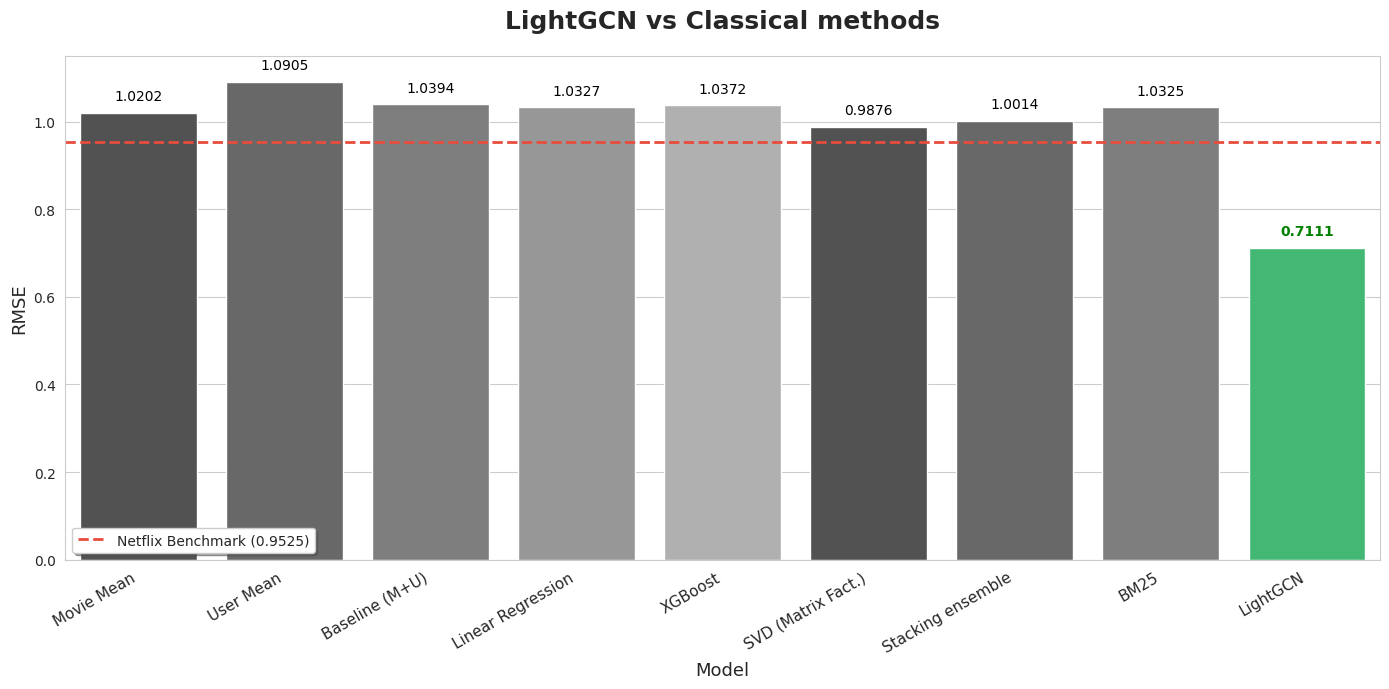

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

results = {
    'Movie Mean': 1.0202,
    'User Mean': 1.0905,
    'Baseline (M+U)': 1.0394,
    'Linear Regression': 1.0327,
    'XGBoost': 1.0372,
    'SVD (Matrix Fact.)': 0.9876,
    'Stacking ensemble': 1.0014,
    'BM25': 1.0325,
    'LightGCN': 0.7111
}

gray_shades = sns.color_palette("Greys_r", n_colors=len(results) + 2)
custom_palette = [
    '#2ecc71' if model == 'LightGCN' else gray_shades[i % 5 + 2]
    for i, model in enumerate(results.keys())
]


plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

ax = sns.barplot(
    x=list(results.keys()),
    y=list(results.values()),
    palette=custom_palette,
    hue=list(results.keys()),
    legend=False
)

plt.axhline(y=0.9525, color='#e74c3c', linestyle='--', linewidth=2, label='Netflix Benchmark (0.9525)')
plt.title('LightGCN vs Classical methods', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('RMSE', fontsize=13)
plt.xlabel('Model', fontsize=13)

plt.ylim(0, 1.15)

plt.xticks(rotation=30, ha='right', fontsize=11)
plt.legend(loc='lower left', frameon=True, shadow=True)

for p in ax.patches:
    height = p.get_height()
    color = 'green' if height < 0.8 else 'black'
    weight = 'bold' if height < 0.8 else 'normal'

    ax.annotate(f'{height:.4f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 12),
                textcoords='offset points',
                fontsize=10,
                fontweight=weight,
                color=color)

plt.tight_layout()
plt.show()